# Simulate a cave emptiing using bernouilli equation, and the darcy-Weissbach

The conceptual model is a cave emptying, in the tunnel, with a hit in a given distance. 
August 2020.

Equation : Q = A * sqrt(2 * g * h)

with Q the flow, A the Area of the outflow section, g the gravity and h the water height in the cave. 
Since the main focus in on the maximum flow and not on the time, we can only consider the cave height and not all its geometry. 

In [3]:
import math
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib
from scipy import stats
from scipy import interpolate
from scipy.optimize import fsolve

## Retrieve Pipe distribution from the NAGRA file

Read Area of conduits

In [16]:
max_Size = 10


max_Size = math.pi * (max_Size/2)**2
data_from_nagra = np.genfromtxt('Size_conduits.csv', delimiter=';')
quantile = data_from_nagra[:,0]
size = data_from_nagra[:,1]

Find_R = interpolate.interp1d(size,quantile)
Max_Quantile = Find_R(max_Size)
quantile = quantile/Max_Quantile


pipe_function = interpolate.interp1d(quantile,size)

Text(0.5, 1.0, 'Distribution of conduits')

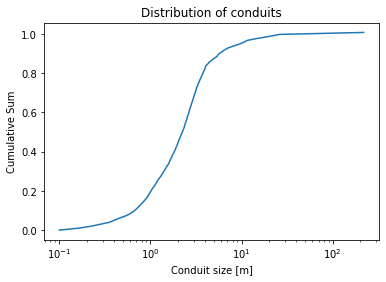

In [17]:
plt.plot(size,quantile)
plt.xscale('log')
plt.xlabel('Conduit size [m]')
plt.ylabel('Cumulative Sum')
plt.title('Distribution of conduits')

## Define the Calculation functions

In [18]:
g = 9.81 # Acceleration of gravity [m/s2]

def f_karman(Rr):
    """ 
    Computes the friction factor for a given rugosity assuming that 
    the Reynolds number is very large
    """
    return 1/(2*np.log10(Rr/3.7))**2


def flux_from_cavity(h,d,L,Rr,verbose=False,rho=998,mu=1.3e-3, cs = 0.5):
    """ 
    Computes the flux from a cavity through a karst conduit to a tunnel 
    using Bernoulli and Darcy-Weisbach equations
    
    input:
    
     h = height of the water level in cavity above the tunnel in [m]
     d = diameter of the conduits in [m]
     L = length of the horizontal condtuit in [m]
     Rr = rugosity of the conduits [unitless ratio] (should be < 0.1)
     
     verbose = a boolean flag, if equals True it prints intermediate results
     rho, mu = density and viscosity
     cs = singular head losses (by default only entrance into conduit)
    
    output:
    
     q = flux in [m3/s]
     
    method:
     a non linear equation solver is used 
     
     two coupled equations are considered
     - one coming from Bernoulli energy balance and Darcy Weisbach
     - the Colenbrook equation to determine the friction factor 
     
     the non linear solver needs an initial solution, therefore solving 
     the problems requires two steps:
      1/ we get an approximate solution assuming that reynolds numbers is very high
      2/ we use this as a starting point for the non linear solver
    
    """    
    
    # Compute approximate solution
    f = f_karman(Rr) # friction factor for high Reynolds number (Karman equation)
    v = np.sqrt( 2*g*h / (1 + cs + f*L/d) ) # Solving Bernoulli for velocity
    
    # Define the system of non linear equations to solve
    def flowproblem(x):
        """
        Takes as an input the two unknowns:
         x[0] is the velocity, and x[1] the friction factor
         
        Returns the values computed for the two equations to solve. These values
        should be equal to zero.
        """
        
        # This is just to improve readibility 
        v,f = x[0], x[1] # flow velocity [m/s] and friction factor
        
        # Initialize the values returned by the function
        y = np.zeros(2)

        # Bernoulli equation: y[0] should be equal to 0 to ensure energy balance
        y[0] = v**2 * (1+ cs + f*L/d)  - 2*g*h
        
        # Colebrook equation written as a function of f and v
        # The Reynolds number is written explicitly
        y[1] = 1/np.sqrt(f) + 2*np.log10(Rr/3.7 + 2.51*mu/(v*rho*d*np.sqrt(f)))
 
        return y
    
    # Solve the non linear problem
    x = fsolve( flowproblem, [v,f] )
    v,f = x[0], x[1]
    
    # Compute the flux in [m3/s]
    q = np.pi * (d/2)**2 * v
    
    # To print detailed results
    if verbose:
        y = flowproblem(x) # For convergence check
        print('input:')
        print('------')
        print(' total height:',h,'[m]')
        print(' diameter:',d,'[m]')
        print(' length:',L,'[m]')
        print(' rugosity:',Rr,'[unitless]')
        print(' mu/rho:',mu/rho,'[m2*s]')
        print(' cs:',cs,'[-]')
        print('output:')
        print('-------')
        print(' velocity:',v,'[m/s]')
        print(' flux:',q,'[m3/s]')
        print(' friction factor:',f,'[unitless]')
        print(' Reynolds number:',v*rho*d/mu,'[unitless]')
        print('convergence check:')
        print('-------')
        print(' Bernoulli equation:',y[0])
        print(' Colenbrook equation:',y[1])
    
    return q

def conduit_diameter(n=1):
    rand = np.random.random(n)
    pipe_area = pipe_function(rand)
    pipe_diameter = 2 * np.sqrt(pipe_area/math.pi)
    return pipe_diameter

## MonteCarlo

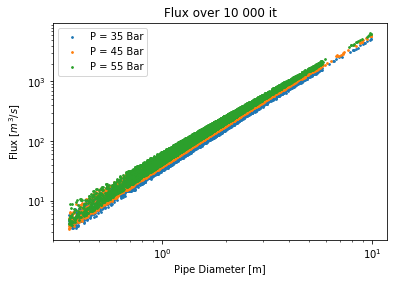

In [31]:
n_sim = 10000
conduit_max_length = 20
Rugosity = [0.02,0.2]
cave_pressures = [35,45,55] 
for cave_pressure in cave_pressures:

    cave_max_height = cave_pressure * 10.197162
    pipe_l = np.random.random(n_sim) * conduit_max_length
    cave_height = np.ones(n_sim) * cave_max_height
    breach_diameter = conduit_diameter(n_sim)
    Rugosity = np.random.random(n_sim) * (Rugosity[1]-Rugosity[0]) + Rugosity[0]
    Q_out = np.empty((n_sim))

    for h,d,L,Rr,i in zip(cave_height,breach_diameter,pipe_l,Rugosity,range(n_sim)):
        Q_out[i] = flux_from_cavity(h,d,L,Rr,verbose=False,rho=998,mu=1.3e-3, cs = 0.5)


    plt.scatter(breach_diameter,Q_out,s=3)
    plt.xlabel('Pipe Diameter [m]')
    plt.ylabel('Flux [$m^3 / s$]')
    plt.xscale('log')
    plt.yscale('log')

    plt.title('Flux over 10 000 it')
plt.legend(['P = 35 Bar','P = 45 Bar','P = 55 Bar'])

Text(0.5, 1.0, 'Flux over 10 000 it. P = ')

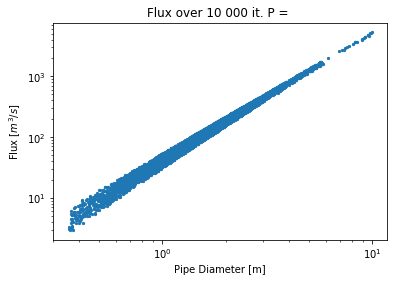

Text(0.5, 0, 'Flux [$m^3 / s$]')

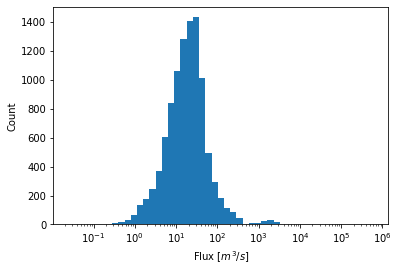

In [50]:

plt.hist(Q_out, bins = 40 ** np.linspace(np.log10(0.1), np.log10(4000), 50))
plt.gca().set_xscale("log")
plt.ylabel('Count')
plt.xlabel('Flux [$m^3 / s$]')

Text(0.5, 0, 'Flux [$m^3 / s$]')

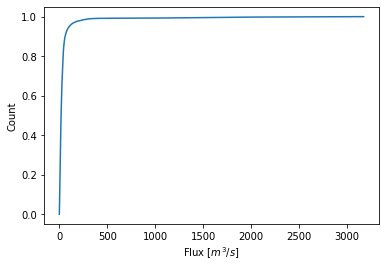

In [52]:
Quart = np.arange(0,1+0.00001,0.00001)
heep = np.quantile(Q_out,Quart)
plt.plot(heep,Quart)

plt.ylabel('Cumulative Function')
plt.xlabel('Flux [$m^3 / s$]')

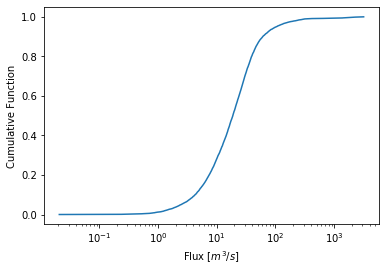

In [53]:
Quart = np.arange(0,1+0.00001,0.00001)
heep = np.quantile(Q_out,Quart)
plt.plot(heep,Quart)

plt.ylabel('Cumulative Function')
plt.xlabel('Flux [$m^3 / s$]')
plt.gca().set_xscale("log")
